# [Advent of Code 2019](http://adventofcode.com/2019)

Jim Mahoney | jimmahoney@bennington.edu | cs.bennington.college | [github](https://github.com/BenningtonComputing/advent-of-code)

## Preparations

In [1]:
# Some of these are from Peter Norvig's 
# github.com/norvig/pytudes/blob/master/ipynb/Advent%202017.ipynb

import numpy as np
from numpy import sin, cos, sqrt, pi, arctan2, degrees, radians
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statistics import mean, median, stdev
from IPython.core.display import HTML
from collections import deque, Counter, OrderedDict, defaultdict
from itertools import permutations
import subprocess
from copy import copy, deepcopy
import functools
from time import time
memoize = functools.lru_cache(None, typed=True)

# Download puzzle input files into e.g. puzzle_input/1.txt .
def puzzle_input(daynumber):
    """ return the open file for given day """
    filename = f"puzzle_inputs/{daynumber}.txt"
    try:
        return open(filename)
    except FileNotFoundError:
        print(f"Oops - couldn't find '{filename}'")

# -- 2D geometry  --

#    Using tuples for points rather than numpy arrays or complex numbers
#    keeps integers as integers so grids work without roundoff errors.
#    Also with vector operations.
def Point(x, y): return (x, y)
def X(p): return p[0]
def Y(p): return p[1]
def dot(p1, p2): return X(p1)*X(p2) + Y(p1)*Y(p2)
def manhattan(p): return abs(X(p)) + abs(Y(p))
def add(p1, p2): return Point(X(p1) + X(p2), Y(p1) + Y(p2))
def subtract(p1, p2): return Point(X(p1) - X(p2), Y(p1) - Y(p2))
def scale(s, p): return Point(s * X(p), s * Y(p))
#    examples :
assert X(Point(3,4))==3 and Y(Point(3,4))==4
assert add(Point(1,2), Point(3,4)) == Point(4,6)
assert subtract(Point(1,2), Point(3,-1)) == Point(-2,3)
assert dot(Point(1,2), Point(10,11)) == 32
assert scale(2, Point(3,4)) == Point(6,8)
assert manhattan(Point(3,-5)) == 8

UP = (0,1)     # traditional euclid geometry conventions
RIGHT = (1,0)  # .
LEFT = (-1,0)  # .
DOWN = (0,-1)  # .
turn_right = { UP:RIGHT, RIGHT:DOWN, DOWN:LEFT, LEFT:UP }
turn_left = { UP:LEFT, LEFT:DOWN, DOWN:RIGHT, RIGHT:UP }

def clockangle(x,y, invert_y=False):
    """ return angle in degrees clockwise from 12:00. """
    if invert_y: y = -y   # use this when y is row number, increasing downward
    angle = 90.0 - degrees(arctan2(y, x))
    if angle < 0.0: angle += 360.0
    return angle

for (x,y,angle) in ((0,1,0.0), (1,1,45.0), (1,0,90.0), (1,-1,135.0), 
                    (0,-1,180.0), (-1,-1,225.0), (-1,0,270.0), (-1,1,315.0)):
    assert clockangle(x,y) == angle, f"{x},{y},{angle}"
assert clockangle(0, -1, invert_y=True) == 0.0

# -- functional utilities

def allsame(xs): return len(set(xs))==1
def allunique(xs): return len(set(xs))==len(xs)
def length(xs): return len(tuple(xs)) # works on filter,map,...
identity = lambda x:x
def first(xs, default=None): 
    try:
        return (tuple(xs))[0]
    except:
        return default
def nth(xs, n, default=None): 
    try:
        return (tuple(xs))[n]
    except:
        return default
def mapt(f, xs): return tuple(map(f, xs)) # tuple(map())
def pairwise(xs): return tuple(zip((tuple(xs))[:-1], (tuple(xs))[1:])) # ((x0,x1), (x1,x2), ...)
# -- tests --
assert first((1,2))==1
assert nth((1,2), 1)==2
assert allsame((1,1,1))==True
assert allsame((1,1,2))==False
assert allunique((1,2,3))==True
assert allunique((1,1,2))==False
assert mapt(lambda x:2*x, (1,2,3)) == (2,4,6)
assert length(filter( lambda x: x<10, range(20))) == 10
assert pairwise(range(4)) == ((0,1), (1,2), (2,3))

# -- constants --

inf = float('inf')
assert inf > 1e99

def show_png(filename, dpi=200, invert=True, background=0.15):
    """ show a png image """
    # Using matplot puts it into the notebook
    # and in the "download as html" single-file 
    # This also works to display the image in the browser,
    # but does not put it into the saved notebook html file.
    #display(HTML("<img style='filter:invert(80%);' src='file.png'>"))    
    png = mpimg.imread(filename)
    height, width = png.shape[0:2]
    dpi=200
    plt.figure(dpi=dpi, figsize=(width/dpi, height/dpi))
    if invert:
        png = background + (1.0-background)*(1.0 - png[:,:,:3])
    plt.imshow(png)
    plt.axis('off')
    plt.show()

# -- data structures --

class Stack:
    def __init__(self, values=[]):
        self.values = deque(values)
    def push(self, value):
        return self.values.append(value)
    def pop(self):
        return self.values.pop()
    def __len__(self):
        return len(self.values)
    def __str__(self):
        return f"Stack({list(self.values)})"
class Queue(Stack):
    def pop(self):
        return self.values.popleft()
    def __str__(self):
        return f"Queue({list(self.values)})"
stack_test = Stack([1,2,3])
stack_test.push(4)
assert stack_test.pop() == 4
assert str(stack_test) == 'Stack([1, 2, 3])'
queue_test = Queue([1,2,3])
queue_test.push(4)
assert queue_test.pop() == 1
assert str(queue_test) == 'Queue([2, 3, 4])'

def expand(values, index, padding=128):
    """ Modify in place and return the list values[] by appending
        zeros to ensure that values[index] is not out of bounds.
        An error is raised if index is negative.
    """
    assert index >= 0, f"Oops: negative index in expand(values, index={index})"
    if index >= len(values):
        space_needed = index - len(values) + 1
        values.extend([0] * (space_needed + padding))
    return values
expand_test = [100, 101, 102]
assert expand(expand_test, 2, padding=0) == [100, 101, 102]
assert expand(expand_test, 5, padding=0) == [100, 101, 102, 0, 0, 0]

# -- numerical methods --

@memoize
def gcd(a, b):
    """ greatest common divisor """
    # wikipedia.org/wiki/Greatest_common_divisor#Euclid's_algorithm
    return a if b == 0 else gcd(b, a % b)
assert gcd(10,15) == gcd(15,10) == 5
assert gcd(16, 16) == 16 and gcd(16, 12) == 4

@memoize
def lcm(a, b):
    """ lowest common multiple """
    # stackoverflow.com/questions/147515/least-common-multiple-for-3-or-more-numbers
    return a * b // gcd(a,b)
assert lcm(10, 15) == 30
assert lcm(24, 16) == 48

@memoize
def reduce(a, b):
    """ return (aa, bb) with same ratio but no common factors"""
    if a == b == 0:
        return (0,0)
    _gcd = abs(gcd(a,b))
    return (a//_gcd, b//_gcd)
assert reduce(24,16) == (3,2)
assert reduce(-4,2) == (-2,1)
assert reduce(0,0) == (0,0)
assert reduce(1,0) == (1,0)
assert reduce(0,-1) == (0,-1)

---
## [Day 1](http://adventofcode.com/2019/day/1) : The Tyranny of the Rocket Equation

In [2]:
# --- input ---
# 85824
# 112173
# ...

day1_raw_lines = puzzle_input(1).readlines()
print(f"The first few raw lines are : {day1_raw_lines[:3]}")
day1 = [int(line.strip()) for line in day1_raw_lines]
print(f"The number of entries is {len(day1)}.")
print(f"The first 3 are {day1[:3]}.")

The first few raw lines are : ['85824\n', '112173\n', '142065\n']
The number of entries is 100.
The first 3 are [85824, 112173, 142065].


### Day 1 Part One

In [3]:
def calc_fuel(mass):
    """ divide by three, round down, and subtract 2 """
    return mass // 3 - 2

test_masses = (12, 14, 1969, 100756)
test_results = (2, 2, 654, 33583)
for (mass, result) in zip(test_masses, test_results):
    assert result == calc_fuel(mass)

day1_part1 = sum(calc_fuel(mass) for mass in day1)
print(f"Day 1 Part 1 is {day1_part1}.")

Day 1 Part 1 is 3453056.


### Day 1 Part Two

In [4]:
def total_fuel(mass, accumulated=0, verbose=False):
    """ repeat and accumulate until not positive """
    if verbose:
        print(f" mass={mass}, accumulated={accumulated}")
    fuel = calc_fuel(mass)
    if fuel < 0:
        return accumulated
    else:
        return total_fuel(fuel, accumulated + fuel, verbose=verbose)

test_masses_2 = (14, 1969, 100756)
test_results_2 = (2, 966, 50346)
for (mass, result) in zip(test_masses_2, test_results_2):
    total = total_fuel(mass, verbose=False)
    #print(f"-- assert mass={mass}, want={result}, got={total} --")
    assert result == total
    
day1_part2 = sum(total_fuel(mass) for mass in day1)
print(f"Day 1 Part 2 is {day1_part2}.")

Day 1 Part 2 is 5176705.


---
## [Day 2](http://adventofcode.com/2019/day/2) : 1202 Program Alarm

In [5]:
# -- input --
# 1,0,0,3,1,1,2,3,1,3,4,3,1,5,0,3,2,6, ...
day2_raw = puzzle_input(2).read().strip()
print(f"The beginning and end of day2_raw is '{day2_raw[:10]}' and '{day2_raw[-10:]}'.")

def parse_intcode(string):
    "Convert '1,2,3' to [1,2,3] "
    return [int(s.strip()) for s in string.split(',')]

day2 = parse_intcode(day2_raw)
print(f"The {len(day2)} integers of day2 are {str(day2[:6])[:-1]} ... {str(day2[-6:])[1:]}.")

The beginning and end of day2_raw is '1,0,0,3,1,' and '9,2,0,14,0'.
The 149 integers of day2 are [1, 0, 0, 3, 1, 1 ... 0, 99, 2, 0, 14, 0].


### Day 2 Part One

In [6]:
# The state of the machine is defined by (ip, intcode) where
#    ip       :  address of next instruction to be executed
#    intcode  :  Intcode program i.e. list of integers 

def addresses(intcodes, ip):
    """ Return the three address (a, b, c) at positions 1,2,3 past ip. """
    return intcodes[ip+1 : ip+4]

def op_add(intcodes, ip):
    (a, b, c) = addresses(intcodes, ip)
    intcodes[c] = intcodes[a] + intcodes[b]
    return (intcodes, ip + 4)

def op_multiply(intcodes, ip):
    (a, b, c) = addresses(intcodes, ip)
    intcodes[c] = intcodes[a] * intcodes[b]
    return (intcodes, ip + 4)

def op_halt(intcodes, ip):
    return (intcodes, -1)   # signal 'finished' with a negative ip.

def reset_1202(intcodes):
    """ reset to 1202 program alarm """
    intcodes[1] = 12
    intcodes[2] = 2
    return intcodes

operations = { 1 : op_add,
               2 : op_multiply,
              99 : op_halt
             }

def run(intcodes, ip=0, reset=True):
    """ Execute the instructions in the intcodes. """
    intcodes = intcodes[:] # work on a copy
    ip = 0
    if reset:
        intcodes = reset_1202(intcodes)
    while True:
        op = operations[intcodes[ip]]
        (intcodes, ip) = op(intcodes, ip)
        if ip < 0:
            return intcodes

test_inputs = ([1,9,10,3,2,3,11,0,99,30,40,50],
               [1,0,0,0,99],
               [2,3,0,3,99],
               [2,4,4,5,99,0],
               [1,1,1,4,99,5,6,0,99]
              )

test_outputs = ([3500,9,10,70, 2,3,11,0, 99, 30,40,50],
                [2,0,0,0,99],
                [2,3,0,6,99],
                [2,4,4,5,99,9801],
                [30,1,1,4,2,5,6,0,99]
               )

for (test_in, test_out) in zip(test_inputs, test_outputs):
    assert run(test_in, reset=False) == test_out
    
day_2_part_1 = run(day2)[0]
print(f"Day 2 Part 1 is {day_2_part_1}.")

Day 2 Part 1 is 4090689.


### Day 2 Part 2

In [7]:
def run2(*inputs, intcodes=day2):
    """ Run the intcodes code with initial values (noun, verb) """
    intcodes = intcodes[:]     # Work on a copy, not the original.
    assert len(inputs) == 2    # Make sure we have two input values.
    intcodes[1:3] = inputs     # Replace intcodes[1] and intcodes[2].
    ip = 0                     # Initialize instruction pointer.
    while True:
        op = operations[intcodes[ip]]           # Get operation at address ip.
        (intcodes, ip) = op(intcodes, ip)       # Get new state by doing it.
        if ip < 0:                              # Done?
            return intcodes[0]

assert run2(12, 2) == 4090689                   # Test that this still gives part 1.

for noun in range(100):
    for verb in range(100):
        if run2(noun, verb) == 19690720:            
            #print(f"noun={noun}, verb={verb}")
            print(f"Day 2 Part 2 is {100*noun+verb}.")
            break

Day 2 Part 2 is 7733.


---
## [Day 3](http://adventofcode.com/2019/day/3) : Crossed Wires

In [8]:
day3_raw = puzzle_input(3).read()
#day3_raw
(day3_wire1, day3_wire2) = ( wire.strip() for wire in puzzle_input(3).readlines() )
print(f"day3_wire1 : length {len(day3_wire1)}, starts '{day3_wire1[:12]}' , ends '{day3_wire1[-12:]}'.")
print(f"day3_wire2 : length {len(day3_wire2)}, starts '{day3_wire2[:12]}' , ends '{day3_wire2[-12:]}'.")

day3_wire1 : length 1471, starts 'R1005,U370,L' , ends '61,D849,R379'.
day3_wire2 : length 1475, starts 'L998,U242,R3' , ends '71,D912,R227'.


### Day 3 Part 1

In [9]:
directions = {'R': Point(1,0),    # Right
              'L': Point(-1,0),   # Left
              'U': Point(0,1),    # Up
              'D': Point(0,-1)    # Down
             }

def point_set(wire):
    """ Return set of points that the wire (e.g. 'L23,R10,U10') goes through """
    result = set()
    location = Point(0,0)
    for segment in wire.split(','):
        direction = directions[segment[0]]
        distance = int(segment[1:])
        for d in range(distance):
            location = add(location, direction)  # Here "add" means geometric vector add.
            result.add(location)                 # Here "add" means append to set.
    return result

def draw(w1, w2):
    """ Draw two wires """
    points1 = point_set(w1)
    points2 = point_set(w2)
    all_points = points1.union(points2)
    shared_points = points1.intersection(points2)
    xmax = max( X(p) for p in all_points ) + 2
    xmin = min( X(p) for p in all_points ) - 2
    ymax = max( Y(p) for p in all_points ) + 2
    ymin = min( Y(p) for p in all_points ) - 2
    origin = Point(0,0)
    for y in range(ymax, ymin-1, -1):
        for x in range(xmin, xmax+1):
            p = Point(x,y)
            if p == origin:
                symbol = '0'
            elif p in shared_points:
                symbol = 'X'     # X marks the spot(s)
            elif p in points1:
                symbol = 'm'
            elif p in points2:
                symbol = 'n'
            else:
                symbol = '.'
            print(' ' + symbol, end='')
        print()

draw('R8,U5,L5,D3', 'U7,R6,D4,L4')  # Illustrated in the problem statement.

def closest(w1, w2):
    """ Manhatten distance to closest crossing """
    return min(manhattan(p) for p in point_set(w1).intersection(point_set(w2)))

tests = ( ('R8,U5,L5,D3', 
           'U7,R6,D4,L4',                              6),
          ('R75,D30,R83,U83,L12,D49,R71,U7,L72', 
           'U62,R66,U55,R34,D71,R55,D58,R83',         159),
          ('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51', 
           'U98,R91,D20,R16,D67,R40,U7,R15,U6,R7',    135)
        )
for (wire1, wire2, answer) in tests:
    assert closest(wire1, wire2) == answer

print()
print(f"Day 3 Part 1 answer is {closest(day3_wire1, day3_wire2)}.")

 . . . . . . . . . . . . .
 . . . . . . . . . . . . .
 . . n n n n n n n . . . .
 . . n . . . . . n . . . .
 . . n . . m m m X m m . .
 . . n . . m . . n . m . .
 . . n . n X n n n . m . .
 . . n . . m . . . . m . .
 . . n . . . . . . . m . .
 . . 0 m m m m m m m m . .
 . . . . . . . . . . . . .
 . . . . . . . . . . . . .

Day 3 Part 1 answer is 1626.


### Day 3 Part 2

In [10]:
def point_steps(wire):
    """ Return dict of {point:steps} for a wire (e.g. 'L23,R10,U10') """
    result = {}
    location = Point(0,0)
    steps = 0
    for segment in wire.split(','):
        direction = directions[segment[0]]
        distance = int(segment[1:])
        for d in range(distance):
            steps += 1
            location = add(location, direction)
            if location not in result:
                # only set steps if this is first visit to this location
                result[location] = steps
    return result

def smallest_total(wire1, wire2):
    """ Return smallest sum of steps at an intersection """
    ps1 = point_steps(wire1)
    ps2 = point_steps(wire2)
    crossings = set(ps1).intersection(set(ps2))
    return min(ps1[point] + ps2[point] for point in crossings)

tests2 = ( ('R8,U5,L5,D3', 
            'U7,R6,D4,L4',                                 30),
           ('R75,D30,R83,U83,L12,D49,R71,U7,L72', 
            'U62,R66,U55,R34,D71,R55,D58,R83',            610),
           ('R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51', 
            'U98,R91,D20,R16,D67,R40,U7,R15,U6,R7',       410)
         )

for (wire1, wire2, answer) in tests2:
    assert smallest_total(wire1, wire2) == answer

print(f"Day 3 Part 2 is {smallest_total(day3_wire1, day3_wire2)}.")

Day 3 Part 2 is 27330.


---
## [Day 4](http://adventofcode.com/2019/day/4) : Secure Container

In [11]:
(day4_low, day4_high) = (int(x) for x in puzzle_input(4).read().strip().split('-'))
print(f"The range is {day4_low} to {day4_high}.")

The range is 307237 to 769058.


### Day 4 Part 1

In [12]:
def six_digits(x):
    """ Return string of six digits. """
    return f"{x:06}"
assert six_digits(3) == '000003'
assert six_digits(123456) == '123456'

def increasing(digits):
    """ True if the digits are increasing. """
    for i in range(5):
        if int(digits[i]) > int(digits[i+1]):
            return False
    return True
assert increasing('111111') == True
assert increasing('223450') == False
assert increasing('123789') == True

def doubles(digits):
    """ Return number of adjacent doubles. """
    count = 0
    for i in range(5):
        if digits[i] == digits[i+1]:
            count += 1
    return count
assert doubles('111111') == 5
assert doubles('223450') == 1
assert doubles('123789') == 0

def doubles_f(digits):
    """ same - functional version """
    # ... just for fun. ;)
    return length(filter(allsame, pairwise(digits)))
assert doubles_f('111111') == 5
assert doubles_f('223450') == 1
assert doubles_f('123789') == 0

def valid(x):
    digits = six_digits(x)
    return increasing(digits) and doubles(digits) > 0

tests = ( (111111, True),
          (223450, False),
          (123789, False)
        )
for (number, answer) in tests:
    assert valid(number) == answer
    
def how_many(f=valid, low=day4_low, high=day4_high):
    count=0
    for i in range(low, high+1):
        if f(i):
            count += 1
    return count

print(f"Day 4 Part 1 is {how_many()}.")

Day 4 Part 1 is 889.


### Day 4 Part 2

In [13]:
def exactly_two(digits):
    """ Return number of two same (not part of larger sequence). """
    count = 0
    for i in range(5):
        if digits[i] == digits[i+1]:
            if i-1 >= 0:
                if digits[i-1] == digits[i+1]:
                    continue
            if i+2 <= 5:
                if digits[i+2] == digits[i]:
                    continue
            count += 1
    return count
assert exactly_two('111333') == 0
assert exactly_two('122233') == 1
assert exactly_two('112233') == 3

def valid2(xs):
    digits = six_digits(xs)
    return increasing(digits) and exactly_two(digits) > 0

tests2 = ( (112233, True),
           (123444, False),
           (111122, True)
        )
for (number, answer) in tests2:
    assert valid2(number) == answer
    
print(f"Day 4 Part 2 is {how_many(f=valid2)}.")

Day 4 Part 2 is 589.


---
## [Day 5](http://adventofcode.com/2019/day/5) : Sunny with a Chance of Asteroids

In [14]:
# Same format as Day 2.
day5_raw = puzzle_input(5).read()
print(f"The beginning and end of day5_raw is '{day5_raw[:10]}' and '{day5_raw[-10:].strip()}'.")
day5 = parse_intcode(day5_raw)
print(f"The {len(day5)} integers of day5 are {str(day5[:6])[:-1]} ... {str(day5[-6:])[1:]}.")

The beginning and end of day5_raw is '3,225,1,22' and '23,99,226'.
The 678 integers of day5 are [3, 225, 1, 225, 6, 6 ... 1, 223, 4, 223, 99, 226].


### Day 5 Part 1

## - IntcodeMachine - 

### REFACTORING NOTE

The Advent of Code 2019 IntcodeCode machine was first introduced on Day 2. 
However, I'm not using my Day 2 code in this Day 5.

On the other hand, this Day 5 code is what I've carried through, extended,
and refactored for the other days that extend the IntcodeMachine - 
Days 7, 9, 11, 13.

So for the full machine definition you must evaluate the cells for all of days 5, 7, 9, 11, 13.

In [115]:

def opcode_modes(instruction):
    """ Return (opcode, (mode_1st, mode_2nd, mode_3rd)) from an instruction """
    digits = f"{instruction:05}"  # five digits e.g. 101 => '00100'
    opcode = int(digits[-2:])
    modes = (int(digits[-3]), int(digits[-4]), int(digits[-5]))
    return (opcode, modes)
assert opcode_modes(199) == (99, (1, 0, 0)) # e.g. ABCDE=00199, return (DE (C,B,A))

ops = {1:'add', 2:'multiply', 3:'read', 4:'write', 99:'halt',
       5:'jmp-if-1', 6:'jmp-if-0', 7:'lt?', 8:'eq?', 9:'base+'}

class IntcodeMachine:
    """ The amazing advent of code 2019 machine ... with all the bells and whistles """
    def __init__(self, code, inputs=None, verbose=False):
        self.code = code[:]  # work on a copy of intcodes program
        self.ip = 0          # instruction pointer = address into code
        self.inputs = [] if inputs == None else inputs[:]
        self.in_ptr = 0      # pointer into inputs
        self.outputs = []
        self.opcode = 0      # placeholder ; set while processing instruction
        self.modes = (0,0,0) # ditto
        self.base = 0        # relative mode address base (from day 9)
        self.running = True
        self.step = 0
        self.verbose = verbose
    def error(self, message):
        self.outputs.append('ERROR: ' + message)
        self.running = False
    def get_code(self, address):
        """ return code[address] """
        # With expanding memory and address checking.
        try:
            self.code = expand(self.code, address)
            return self.code[address]
        except IndexError:
            self.error(f"get code[{address}] ERROR : out of bounds")
            return 0
    def set_code(self, address, value):
        """ Put value into code[address] """
        # With expanding memory and address checking
        try:
            self.code = expand(self.code, address)
            self.code[address] = value
        except IndexError:
            self.error(f"set code[{address}]={value} out of bounds")
    def nth_address(self, n):
        """ return n'th parameter as address, including mode variations """
        parameter = self.get_code(self.ip + n)
        mode = self.modes[n - 1]
        if mode == 0:         # address mode
            return parameter
        elif mode == 2:       # relative mode; day 9
            return parameter + self.base
        else:
            # Note that immediate mode (i.e. 1) is illegal here,
            # since an "immediate" number is a value not an address.
            self.error(f"set_nth_value illegal mode={mode}")
            return None
    def nth_value(self, n): 
        """ return n'th parameter's value """
        #assert n in (1, 2)  # Only used for 1st or 2nd param ... I think.
        parameter = self.get_code(self.ip + n)
        mode = self.modes[n - 1]
        if mode == 1:                       # immediate mode
            return parameter                
        elif mode == 0:                     # address mode
            return self.get_code(parameter)
        elif mode == 2:                     #  relative mode; day 9
            return self.get_code(parameter + self.base)
        else:
            self.error(f"nth_value illegal mode={mode}")
            return 0
    def set_opcode_modes(self):
        """ Set current opcode and modes from code at ip. """
        instruction = self.get_code(self.ip)
        (self.opcode, self.modes) = opcode_modes(instruction)
    def run(self, new_inputs=None):
        """ Run the machine, with an optional list of new inputs. Return new outputs. """
        self.running = True
        len_old_outputs = len(self.outputs)
        if new_inputs:
            self.inputs.extend(new_inputs)
        while self.running:
            IM_step(self)
        return self.outputs[len_old_outputs:]
    def is_halted(self):
        """ True if the last instruction seen was halt."""
        # Refactored for machine control in Day 11.
        # The machine can now be in a running=False is_halted=False 
        # paused situation if it tries to read the next input but doesn't find it.
        return ops[self.opcode] == 'halt'
    def next_input(self, new_input):
        """ Send another input into the machine. """
        self.inputs.append(new_input)
    def last_output(self):
        """ Return last output produced by the machine. """
        return self.outputs[-1]
    def state(self):
        """ return string representation of current machine state """
        # including next instruction and parameters 
        ip = self.ip
        modes = f"{self.modes[0]},{self.modes[1]},{self.modes[2]}"
        params = f"{self.get_code(ip+1)},{self.get_code(ip+2)},{self.get_code(ip+3)}"
        return (f"{self.step}: {ops[self.opcode]}" 
                f" ip={self.ip} base={self.base}"
                f" modes={modes} params={params}"
                f" in={self.inputs} out={self.outputs}" )

def IM_add(self):
    """ IntcodeMachine addition operation. """
    values = (self.nth_value(1), self.nth_value(2))
    address = self.nth_address(3)   # parameter 3 is address (mode dependent)
    self.set_code(address, values[0] + values[1])
    self.ip += 4  # skip past (instruction, param_1, param_2, param_3)
    
def IM_multiply(self):
    """ IntcodeMachine multiplication operation. """
    values = (self.nth_value(1), self.nth_value(2))
    address = self.nth_address(3)   # parameter 3 is address (mode dependent)
    self.set_code(address, values[0] * values[1])
    self.ip += 4  # skip past (instruction, param_1, param_2, param_3)
    
def IM_read(self):
    """ IntcodeMachine read from input; put at address in parameter 1 """
    address = self.nth_address(1)   # parameter 1, mode dependent
    try:
        input_value = self.inputs[self.in_ptr]
    except IndexError:
        # Refactored for Day 11 - a third way to run the machine.
        # (See also Day 7 Part 2, which runs 1 input to get 1 output.)
        # Tried to read but no input available.
        # So stop here, back up the step counter, leave machine state the same,
        # ready to try this instruction after more input is added.
        self.step -= 1
        self.running = False
        return
    self.set_code(address, input_value)
    self.in_ptr += 1    # increment input pointer
    self.ip += 2        # skip past (instruction, param_1)
    
def IM_write(self):
    """ IntcodeMachine append to outputs[] the value given by parameter 1 """
    value = self.nth_value(1)   # value of parameter 1
    self.outputs.append(value)  # write to output
    self.ip += 2                # skip past (instruction, param_1)
    
def IM_halt(self):
    self.running = False

# Create the IntcodeMachine operator jump table if it isn't already defined.
# (The try/except here avoids stomping on a later, fancier version IM_ops 
# if this cell is evaluated out of order.)
try:
    IM_ops          # Defined already?
except NameError:
    IM_ops = {}     # If not, initialize it.
    
# IntcodeMachine opcodes ... but see also Day 5 Part 2, Day 7, and Day 9.
IM_ops[1] = IM_add
IM_ops[2] = IM_multiply
IM_ops[3] = IM_read
IM_ops[4] = IM_write
IM_ops[99] = IM_halt

def IM_step(self):
    """ Run one step on the IntcodeMachine ."""
    self.set_opcode_modes()
    operation = IM_ops[self.opcode]
    if self.verbose:
        print(self.state())
    operation(self)
    self.step += 1

# First example: an intcode program that copies input[0] to output.
assert IntcodeMachine([3,0,4,0,99], [1234, 5678]).run() == [1234]

# A second example given in the problem statement.
im_example_2 = IntcodeMachine([1002,4,3,4,33], [])
im_example_2.run()
assert im_example_2.outputs == []
assert im_example_2.code == [1002, 4, 3, 4, 99]

day5_part1_outputs = IntcodeMachine(day5, [1]).run()
day5_part1_diagnostic_tests = day5_part1_outputs[:-1]
day5_part1_diagnostic_code = day5_part1_outputs[-1]
assert all(output==0 for output in day5_part1_diagnostic_tests)
print(f"Day 5 Part 1 is {day5_part1_diagnostic_code}.")

Day 5 Part 1 is 16348437.


### Day 5 Part 2

In [116]:
# more opcodes ...

def IM_jump_if(self, test_func):
    """ Set ip to value in 2nd_param if test_func(1st_param). """
    switch = self.nth_value(1)
    address = self.nth_value(2)
    if test_func(switch):
        self.ip = address  # jump to new address
    else:
        self.ip += 3       # skip past (opcode, param_1, param_2)
    
def IM_jump_if_true(self):
    """ Set ip to value in 2nd_param if 1st_param is nonzero. """
    IM_jump_if(self, lambda s: s != 0)

def IM_jump_if_false(self):
    """ Set ip to value in 2nd_param if 1st_param is zero. """
    IM_jump_if(self, lambda s: s == 0)

def IM_1_or_0_if(self, comparison):
    """ Store 1 at 3rd_param address if comparison(1st_param, 2nd_param), 
        store 0 otherwise. """
    (switch1, switch2) = (self.nth_value(1), self.nth_value(2))
    address = self.nth_address(3)
    if comparison(switch1, switch2):
        self.set_code(address, 1)
    else:
        self.set_code(address, 0)
    self.ip += 4  # skip past opcode + 3 parameters
    
def IM_less_than(self):
    """ Store 1 at 2nd_param address if 1st_param < 2nd_param, 
        store 0 otherwise """
    IM_1_or_0_if(self, lambda a,b: a<b)

def IM_equals(self):
    """ Store 1 at 2nd_param address if 1st_param == 2nd_param, 
        store 0 otherwise """
    IM_1_or_0_if(self, lambda a,b: a==b)

# add more opcodes to the IntcodeMachine    
    
IM_ops[5] = IM_jump_if_true
IM_ops[6] = IM_jump_if_false
IM_ops[7] = IM_less_than
IM_ops[8] = IM_equals
    
# ... and more tests.

tests = ( ([3,9,8,9,10,9,4,9,99,-1,8], 8, 1),   # input 8, position
          ([3,9,8,9,10,9,4,9,99,-1,8], 9, 0),   # input not 8, position
          ([3,3,1108,-1,8,3,4,3,99],   8, 1),   # input 8, immediate
          ([3,3,1107,-1,8,3,4,3,99],   8, 0),   # input not 8, immediate
          ([3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9], 0, 0), # jump position
          ([3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9], 1, 1), # jump position
          ([3,3,1105,-1,9,1101,0,0,12,4,12,99,1], 0, 0),   # jump immediate
          ([3,3,1105,-1,9,1101,0,0,12,4,12,99,1], 1, 1),   # jump immediate
          ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 5, 999),    # below 8
           ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 8, 1000),   # equal to 8
           ([3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
            1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
            999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99], 11, 1001)   # greater than 8
        )

for (intcode, in_value, out_value) in tests:
    assert IntcodeMachine(intcode, [in_value]).run() == [out_value], (intcode, out_value)

#(intcode, in_value, out_value) = tests[4]
#assert IntcodeMachine(intcode, [in_value]).run() == [out_value], (intcode, out_value)

day5_part2_outputs = IntcodeMachine(day5, [5]).run()
assert len(day5_part2_outputs) == 1
print(f"Day 5 Part 2 is {day5_part2_outputs[0]}.")

Day 5 Part 2 is 6959377.


---
## [Day 6](http://adventofcode.com/2019/day/6) : Universal Orbit Map

In [117]:
day6_raw = puzzle_input(6).readlines()
def parse_day6(lines):
    return tuple(line.strip().split(')') for line in lines)
day6 = parse_day6(day6_raw)
# Each line of the puzzle input is a directed edge in a tree.
print(f"Puzzle input has {len(day6)} edges; ", end='')
print(f"first three are {day6[:3]}.")

example6 = parse_day6("COM)B\nB)C\nC)D\nD)E\nE)F\nB)G\nG)H\nD)I\nE)J\nJ)K\nK)L".split('\n'))
print(f"The example has {len(example6)} edges; first three are {example6[:3]}. ")

Puzzle input has 985 edges; first three are (['PJK', 'X3G'], ['ZM3', 'JGN'], ['YYF', '614']).
The example has 11 edges; first three are (['COM', 'B'], ['B', 'C'], ['C', 'D']). 


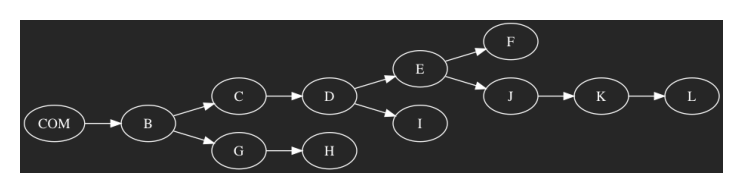

In [118]:
def make_graph_png(name, edges, graphtype='digraph', direction='LR'):
    """ Create graph spec name.dot and graph image name.png using graphviz """
    # command line : "dot -Tpng day6.dot > day6.png "
    filename = name + '.dot'
    with open(filename, 'w') as graphviz:
        graphviz.write(f'{graphtype} {{\n rankdir="{direction}"; \n')
        for (a,b) in edges:
            graphviz.write(f' "{a}" -> "{b}"; \n')
        graphviz.write('}\n')
    dot_command = f"dot -Tpng {filename} > {name}.png"
    dot_result = subprocess.run(dot_command, shell=True, 
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if dot_result.returncode != 0:
        print(f"subprocess.run({dot_command})")
        print(f"  stdout: '{dot_result.stdout}'")
        print(f"  stdout: '{dot_result.stdout}'")
make_graph_png(name='day6', edges=day6)  # day6.png is too big to show here.
make_graph_png(name='day6_example', edges=example6)
show_png('day6_example.png')    

### Day 6 Part 1

In [119]:
class Node:
    """ node in a tree """
    def __init__(self, name):
        self.name = name
        self.mom = None
        self.kids = []
    def __repr__(self):
        return f"Node('{self.name}'')"
    def neighbors(self):
        if self.mom:
            return self.kids + [self.mom]
        else:
            return self.kids

class Tree:
    """ tree of nodes """
    def __init__(self, edges):
        self._nodes = {}  # {name:node}
        for (mom_name, kid_name) in edges:
            node_mom = self.get_node(mom_name)
            node_kid = self.get_node(kid_name)
            node_kid.mom = node_mom
            node_mom.kids.append(node_kid)
        self.root = next(filter(lambda node: node.mom==None, self.nodes()))
    def __repr__(self):
        return f"<Tree root='{self.root.name}' len={len(self)} at {hex(id(self))}>"
    def __len__(self):
        return len(self._nodes)
    def nodes(self):
        return self._nodes.values()
    def get_node(self, name):
        """ get or create Node(name) & put into  name_node dict """
        node = self._nodes.get(name, None)
        if not node:
            node = Node(name)
            self._nodes[name] = node
        return node        

def set_orbits(tree, node=None):
    """ recursively set orbit values in nodes, top to bottom depth-first """
    if not node:
        node = tree.root
        node.orbits = 0
    else:
        node.orbits = node.mom.orbits + 1
    for node in node.kids:
        set_orbits(tree, node)

def total_orbits(tree):
    set_orbits(tree)
    return sum(node.orbits for node in tree.nodes())

example_tree = Tree(example6)
print('example', example_tree, 'has', total_orbits(example_tree), 'orbits.\n')

day6_tree = Tree(day6)
print(f"Day 6 Part 1 is {total_orbits(day6_tree)}.")

example <Tree root='COM' len=12 at 0x7fb931292730> has 42 orbits.

Day 6 Part 1 is 106065.


### Day 6 Part 2

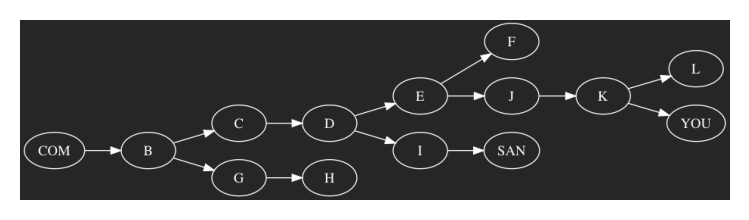

In [120]:
example6b = parse_day6("COM)B,B)C,C)D,D)E,E)F,B)G,G)H,D)I,E)J,J)K,K)L,K)YOU,I)SAN".split(','))
make_graph_png(name='day6_example_b', edges=example6b)
show_png('day6_example_b.png')   

In [121]:
def graph_distance(tree, node1, node2=None):
    """ Return shortest distance from node1 to node2,
        or just update all node.distance shortest to node1 """
    for node in tree.nodes():
        node.distance = inf
        node.back = None    # node backwards towards node1
    fringe = Queue([node1])
    while fringe:
        node = fringe.pop()
        #print(f"looking at '{node}'")
        previous_distance = node.back.distance if node.back else -1
        node.distance = previous_distance + 1
        if node == node2:
            break
        for neighbor in node.neighbors():
            if neighbor.distance > node.distance:
                fringe.push(neighbor)
                neighbor.back = node
    if node2:
        return node2.distance

b_tree = Tree(example6b)
g = b_tree.get_node('G')
d = b_tree.get_node('D')
j = b_tree.get_node('J')
assert graph_distance(b_tree, g, d) == 3
assert graph_distance(b_tree, g, j) == 5

(you_orbit, san_orbit) = (day6_tree.get_node(name).mom for name in ('YOU', 'SAN'))
print(f"Day 6 Part 2 answer is {graph_distance(day6_tree, you_orbit, san_orbit)}.")

Day 6 Part 2 answer is 253.


---
## [Day 7](http://adventofcode.com/2019/day/7) : Amplification Circuit

In [122]:
# Another IntcodeMachine problem; see Day 2 & 5
day7_raw = puzzle_input(7).readline().strip()
day7 = parse_intcode(day7_raw)
print(f"The day 7 input starts with '{day7_raw[:19]}' and has ")
print(f"size {len(day7)}, min {min(day7)}, max {max(day7)}, start {day7[:4]}, end {day7[-4:]}.")

The day 7 input starts with '3,8,1001,8,10,8,105' and has 
size 515, min 0, max 99999, start [3, 8, 1001, 8], end [9, 4, 9, 99].


### Day 7 Part 1

In [123]:

def amplifier(intcode, phases):
    """ Given an intcode machine and phases e.g. (1,2,3,4,0) , return the last output """
    #  phases is a permutation of (0,1,2,3,4)
    #  buffer[0] = 0 ; buffer[5] is the last output and "to thrusters" value
    #    (phases[0], buffer[0]) -> A amp[0] -> buffer[1]
    #    (phases[1], buffer[1]) -> B amp[1] -> buffer[2]
    #    (phases[2], buffer[2]) -> C amp[2] -> buffer[3]
    #    (phases[3], buffer[3]) -> D amp[3] -> buffer[4]
    #    (phases[4], buffer[4]) -> E amp[4] -> buffer[5]
    buffer = [0]*6
    for i in range(5):
        machine_input = (phases[i], buffer[i])
        buffer[i+1] = IntcodeMachine(intcode, machine_input).run()[0]
    return buffer[5]

tests = ( ([3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0], (4,3,2,1,0), 43210),
          ([3,23,3,24,1002,24,10,24,1002,23,-1,23,
            101,5,23,23,1,24,23,23,4,23,99,0,0], (0,1,2,3,4), 54321),
          ([3,31,3,32,1002,32,10,32,1001,31,-2,31,1007,31,0,33,
            1002,33,7,33,1,33,31,31,1,32,31,31,4,31,99,0,0,0], (1,0,4,3,2), 65210)
        )
for (machine, phase, result) in tests:
    assert amplifier(machine, phase) == result

def max_amplifier(machine):
    """ return maximum amplifier() result from all phase permutations """
    return max(amplifier(machine, phases) for phases in permutations((0,1,2,3,4)))

for (machine, _, result) in tests:
    assert max_amplifier(machine) == result
    
print(f"Day 7 Part 1 is {max_amplifier(day7)}.")

Day 7 Part 1 is 440880.


### Day 7 Part 2

In [124]:

def IM_run_in_out(self, new_input):
    """ given one new input, return next new output """
    # A new way to run an IntcodeMachine (see day 2 & day 5).
    # This version sends in one new input, and stops when a new output is produced,
    # leaving the machine in a "suspended but still running" state.
    # ADDED FOR DAY 7 WORK
    self.inputs = self.inputs + [new_input]
    old_output_size = len(self.outputs)
    while self.running and (len(self.outputs) == old_output_size):
        IM_step(self)
    return self.outputs[-1]

def loop_amplifier(intcode, phases):
    """ Continue to run the machines, each output to the next input, until halt. """
    machines = [IntcodeMachine(intcode, [phases[m]]) for m in range(5)]
    signal = 0
    while True:
        for m in range(5):
            signal = IM_run_in_out(machines[m], signal)
        if not machines[4].running:
            return signal

examples_b = ( ([3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,
                 27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5], (9, 8, 7, 6, 5), 139629729),
               ([3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,
                 -5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,
                 53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10], (9,7,8,5,6), 18216)
             )
for (code, phases, result) in examples_b:
    assert loop_amplifier(code, phases) == result

def max_loop_amplifier(machine):
    """ return maximum loop_amplifier() result from all phase permutations """
    return max(loop_amplifier(machine, phases) for phases in permutations((5, 6, 7, 8, 9)))

print(f"Day 7 Part 2 is {max_loop_amplifier(day7)}.")

Day 7 Part 2 is 3745599.


---
## [Day 8](http://adventofcode.com/2019/day/8) : Space Image Format

In [125]:
day8_raw = puzzle_input(8).read().strip()
def parse_day8(string):
    return mapt(int, string)
day8 = parse_day8(day8_raw)
print(f"Input is a long string of digits, length {len(day8)}, max {max(day8)}, min {min(day8)}.")
print(f"First 10 are {day8[:10]}; last 10 are {day8[-10:]}.")

Input is a long string of digits, length 15000, max 2, min 0.
First 10 are (2, 1, 1, 2, 0, 2, 1, 2, 1, 2); last 10 are (1, 1, 1, 1, 2, 2, 2, 1, 1, 0).


### Day 8 Part 1

In [126]:
width = 25
height = 6
pixels = len(day8) // (width*height)
# 'C' is "C" order, last index fastest i.e. [layer, row, column]
image = np.array(day8).reshape(pixels, height, width)
print(f"image shape (layer, row, column) is {image.shape}")
print(f"so layer 0 is \n{image[0,:,:]}.")
print(f"and layer 99 is \n{image[99,:,:]}.")

image shape (layer, row, column) is (100, 6, 25)
so layer 0 is 
[[2 1 1 2 0 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2]
 [1 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2]
 [1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 0 2 2 2]
 [2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2]
 [2 2 1 0 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 0 1 2 2 2 2]].
and layer 99 is 
[[0 0 2 2 1 1 2 2 1 0 0 2 0 1 0 1 0 2 1 2 1 1 1 0 2]
 [0 1 0 0 0 0 0 0 0 1 1 2 0 0 1 1 2 1 0 0 0 0 2 2 0]
 [1 2 2 0 1 1 2 1 0 2 2 0 1 1 0 1 0 0 1 2 0 0 0 0 2]
 [2 2 2 2 0 2 2 0 2 2 1 2 0 0 2 2 0 1 2 2 1 1 1 0 2]
 [0 2 0 0 0 1 0 2 0 0 1 2 0 2 0 0 0 2 0 0 1 0 0 1 0]
 [2 1 2 1 0 0 0 2 2 0 1 0 0 1 0 1 1 1 1 2 2 2 1 1 0]].


In [127]:
counts = tuple(Counter(image[i,:,:].flatten()) for i in range(100))
zero_counts = tuple(c[0] for c in counts)
i = zero_counts.index(min(zero_counts))
print(f"Day 8 Part 1 is {counts[i][1] * counts[i][2]}.")

Day 8 Part 1 is 1935.


### Day 8 Part 2

[[0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0]]


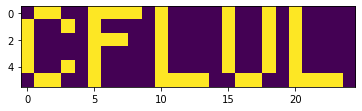

In [128]:
def color(stack):
    """ return color of stack of pixels """
    # return first element that isn't 2.
    for pixel in stack:
        if pixel != 2:
            return pixel
assert color((0,1,2,0)) == 0
assert color((2,1,2,0)) == 1

final = np.zeros((height, width), int)
for row in range(height):
    for col in range(width):
        final[row, col] = color(image[:,row,col])
print(final)
plt.imshow(final);

---
## [Day 9](http://adventofcode.com/2019/day/9) : Sensor Boost

In [129]:
# Another IntcodeMachine problem; see Day 2, 5, 7
day9_raw = puzzle_input(9).readline().strip()
day9 = parse_intcode(day9_raw)
print(f"The day 9 input starts with '{day9_raw[:19]}' and has ")
print(f"size {len(day9)}, min {min(day9)}, max {max(day9)}, start {day9[:4]}, end {day9[-4:]}.")

The day 9 input starts with '1102,34463338,34463' and has 
size 973, min -34, max 34463338, start [1102, 34463338, 34463338, 63], end [-3, 2105, 1, 0].


### Day 9 Part 1

In [130]:
# To add these new "relative mode" features
# and arbitrary machine length, I backtracked 
# and refactored the IntcodeMachine class in day 5 parts 1 & 2.
# Then I re-ran all the cells to make sure the old tests passed.
#
# Here's the additional code needed in addition to the refactoring.

def IM_adjust_base(self):
    """ Change the relative address base """
    self.base += self.nth_value(1)
    self.ip += 2       # skip past (opcode, param_1)

IM_ops[9] = IM_adjust_base

# -- tests --

quine = [109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99]
assert IntcodeMachine(quine).run() == quine

sixteen_digits = [1102,34915192,34915192,7,4,7,99,0]
assert len(str(IntcodeMachine(sixteen_digits).run()[0])) == 16

assert IntcodeMachine([104,1125899906842624,99]).run() == [1125899906842624]

# -- BOOST program --

boost1 = IntcodeMachine(day9, [1])
boost1_out = boost1.run()
assert len(boost1_out) == 1

print(f"Day 9 Part 1 is {boost1_out[0]} in {boost1.step} steps.")

Day 9 Part 1 is 2427443564 in 208 steps.


### Day 9 Part 2

In [131]:
"You now have a complete Intcode computer."

boost2 = IntcodeMachine(day9, [2])
print(f"Day 9 Part 2 is {boost2.run()[0]} ... in {boost2.step} steps.")

Day 9 Part 2 is 87221 ... in 371206 steps.


In [132]:
# boost 1 verbose ... decompiled, as it were.
IntcodeMachine(day9, [1], verbose=True).run()

0: multiply ip=0 base=0 modes=1,1,0 params=34463338,34463338,63 in=[1] out=[]
1: lt? ip=4 base=0 modes=0,1,0 params=63,34463338,63 in=[1] out=[]
2: jmp-if-1 ip=8 base=0 modes=0,1,0 params=63,53,1102 in=[1] out=[]
3: multiply ip=11 base=0 modes=1,1,0 params=1,3,1000 in=[1] out=[]
4: base+ ip=15 base=0 modes=1,0,0 params=988,209,12 in=[1] out=[]
5: base+ ip=17 base=988 modes=2,0,0 params=12,9,1000 in=[1] out=[]
6: base+ ip=19 base=991 modes=0,0,0 params=1000,209,6 in=[1] out=[]
7: base+ ip=21 base=994 modes=2,0,0 params=6,209,3 in=[1] out=[]
8: base+ ip=23 base=997 modes=2,0,0 params=3,203,0 in=[1] out=[]
9: read ip=25 base=1000 modes=2,0,0 params=0,1008,1000 in=[1] out=[]
10: eq? ip=27 base=1000 modes=0,1,0 params=1000,1,63 in=[1] out=[]
11: jmp-if-1 ip=31 base=1000 modes=0,1,0 params=63,65,1008 in=[1] out=[]
12: multiply ip=65 base=1000 modes=1,1,0 params=26,1,1005 in=[1] out=[]
13: add ip=69 base=1000 modes=1,1,0 params=0,24,1019 in=[1] out=[]
14: multiply ip=73 base=1000 modes=1,1,0 

[2427443564]

---
## [Day 10](http://adventofcode.com/2019/day/10) : Monitoring Station

In [133]:
day10_raw = puzzle_input(10).read().strip()

print("The start of day10_raw is")
print(day10_raw[:50], "\n")

The start of day10_raw is
.###..#......###..#...#
#.#..#.##..###..#...#.#
#. 



In [134]:
def to_points(string):
    """ Turn e.g. '#.#\n..#\n' into a set of (x,y) points. """
    points = set()
    lines = string.strip().split('\n')
    _n_rows = len(lines)
    _n_cols = len(lines[0])
    for row in range(_n_rows):
        for column in range(_n_cols):
            if lines[row][column] == '#':
                x = column           # x positive to right
                y = row             # y positive DOWN (... is what they're using in the problem)
                points.add((x,y))
    return points
day10_points = to_points(day10_raw)
print(f"Number of satellites in day 10 is {len(day10_points)}.")

Number of satellites in day 10 is 309.


### Day 10 Part 1

In [135]:
# Given a satellite (i.e. # mark) S1, for every other satellite S2 
# there is a vector S1 -> S2 giving its direction. There is at 
# least one satellite in that direction (S2) and there can be no
# more than one, since the first one in that direction blocks the others.
#
# Therefore counting the number visible is the same as counting the number
# of unique directions, where the length of the direction doesn't matter.
# 
# So first treat each direction as a fraction (a,b) and reduce it
# to its simplest form, then put 'em into a set. The number visible 
# is then just the size of the set.

def direction(p2, p1):
    """ return direction to p2 from p1 in reduced form. """
    return reduce(*subtract(p2, p1))
assert direction((20,20), (10,10)) == (1, 1)
assert direction((5,6), (-5,21)) == (2, -3)

def count_visible(point, points):
    """ return number of points p visible from given point """
    directions = set()
    for p in points:
        heading = direction(p, point)
        if heading != (0, 0):  # can't be visible from yourself
            directions.add(direction(point, p))
    return len(directions)

def most_visible(raw):
    """ return (point, n_visible) for point with highest visibility to others """
    points = to_points(raw)
    best = ((None, None), -1)
    for p in points:
        n_visible = count_visible(p, points)
        if n_visible > best[1]:
            best = (p, n_visible)
    return best


In [136]:
tests = (
("""
.#..#
.....
#####
....#
...##
""", 3,4, 8),
    
("""
......#.#.
#..#.#....
..#######.
.#.#.###..
.#..#.....
..#....#.#
#..#....#.
.##.#..###
##...#..#.
.#....####
""", 5, 8, 33),
    
("""
#.#...#.#.
.###....#.
.#....#...
##.#.#.#.#
....#.#.#.
.##..###.#
..#...##..
..##....##
......#...
.####.###.
""", 1, 2, 35),

("""
.#..#..###
####.###.#
....###.#.
..###.##.#
##.##.#.#.
....###..#
..#.#..#.#
#..#.#.###
.##...##.#
.....#.#..
""", 6, 3, 41),
    
("""
.#..##.###...#######
##.############..##.
.#.######.########.#
.###.#######.####.#.
#####.##.#.##.###.##
..#####..#.#########
####################
#.####....###.#.#.##
##.#################
#####.##.###..####..
..######..##.#######
####.##.####...##..#
.#####..#.######.###
##...#.##########...
#.##########.#######
.####.#.###.###.#.##
....##.##.###..#####
.#.#.###########.###
#.#.#.#####.####.###
###.##.####.##.#..##
""", 11, 13, 210)
)

for (grid, x, y, count) in tests:
    assert most_visible(grid) == ((x,y), count)
    
# Passed all tests.

In [137]:
(station, count) = most_visible(day10_raw)
print(f"Station position is {station}.")
print(f"Day 10 Part 1 (number visible from there) is {count}.")

Station position is (19, 11).
Day 10 Part 1 (number visible from there) is 230.


### Day 10 Part 2

In [138]:
# Given station position, store information for other satellites in a dict
#   { direction : (x1,y2), (x2,y2), ... }
# Then sort directions by clockangle, and sort points by distance to station.

def laser_order(station, raw_map):
    """ return [(x1,y1), (x2,y2), ...]  coords of zapped satellites in order """
    satellites = {}                 #  { heading : [(distance, point), (distance, point), ... }
    points = to_points(raw_map)
    for p in points:
        heading = direction(p, station)
        if heading != (0, 0):  # only looking at other satellites, not this one
            angle = clockangle(*heading, invert_y=True)
            key = angle
            if not key in satellites:
                satellites[key] = []
            vector = subtract(p, station)
            distance = dot(vector, vector)
            satellites[key].append((distance, p))
    for key in satellites:
        satellites[key] = sorted(satellites[key])
    by_angle = sorted([(angle, data) for (angle, data) in satellites.items()])
    just_data = [data for (angle, data) in by_angle]
    zap_order = []
    while True:
        maybe_done = True
        for i in range(len(just_data)):
            data = just_data[i]
            try:
                (distance, pt) = data.pop(0)
                zap_order.append(pt)
                maybe_done = False
            except IndexError:
                pass
        if maybe_done:
            break
    return {i+1:zap_order[i] for i in range(len(zap_order))}

if False:
    example_X = """
.#....#####...#..
##...##.#####..##
##...#...#.#####.
..#.....#...###..
..#.#.....#....##
"""
    best_X = (8,3)
    # By inspection, this looks like it is consistent with the answers given.
    print("(station, visible) for example_X is ", most_visible(example_X))
    print("number of satellites in example_X is ", len(to_points(example_X)))
    print(laser_order(best_X, example_X))

example_big = """
.#..##.###...#######
##.############..##.
.#.######.########.#
.###.#######.####.#.
#####.##.#.##.###.##
..#####..#.#########
####################
#.####....###.#.#.##
##.#################
#####.##.###..####..
..######..##.#######
####.##.####...##..#
.#####..#.######.###
##...#.##########...
#.##########.#######
.####.#.###.###.#.##
....##.##.###..#####
.#.#.###########.###
#.#.#.#####.####.###
###.##.####.##.#..##
"""
best_big = (11, 13)
test_big = (
  (  1, (11, 12)),     # The 1st asteroid to be vaporized is at 11,12.
  (  2, (12,  1)),     # The 2nd asteroid to be vaporized is at 12,1.
  (  3, (12,  2)),     # The 3rd asteroid to be vaporized is at 12,2.
  ( 10, (12,  8)),     # The 10th asteroid to be vaporized is at 12,8.
  ( 20, (16,  0)),     # The 20th asteroid to be vaporized is at 16,0.
  ( 50, (16,  9)),     # The 50th asteroid to be vaporized is at 16,9.
  (100, (10, 16)),     # The 100th asteroid to be vaporized is at 10,16.
  (199, ( 9,  6)),     # The 199th asteroid to be vaporized is at 9,6.
  (200, ( 8,  2)),     # The 200th asteroid to be vaporized is at 8,2.
  (201, (10,  9)),     # The 201st asteroid to be vaporized is at 10,9.
  (299, (11,  1))      # The 299th and final asteroid to be vaporized is at 11,1.
)

large_result = laser_order(best_big, example_big)
for (nth, point) in test_big:
    assert large_result[nth] == point

# -- passed tests --

In [139]:
def bet_value(pt):
    return 100 * pt[0] + pt[1]

zap_order = laser_order(station, day10_raw)
print(f"Day 10 Part 2 is {bet_value(zap_order[200])}.")

Day 10 Part 2 is 1205.


---
## [Day 11](http://adventofcode.com/2019/day/11) : Space Police

In [140]:
# Yet another IntcodeMachine problem; see Day 2 & 5, 7, 9.
day11_raw = puzzle_input(11).readline().strip()
day11 = parse_intcode(day11_raw)
print(f"The day 11 input starts with '{day11_raw[:19]}' and has ")
print(f"size {len(day11)}, min {min(day11)}, max {max(day11)}, start {day11[:4]}, end {day11[-4:]}.")

The day 11 input starts with '3,8,1005,8,336,1106' and has 
size 658, min -5, max 937151013780, start [3, 8, 1005, 8], end [-5, 2105, 1, 0].


### Day 11 Part 1

In [141]:
_unpainted_ = 0     # At first I thought this should be distinguished from black.
_black_ = 0
_white_ = 1
_turning = { 0: turn_left, 1: turn_right }  # see Preperations at top of this notebook.
robot_style = {UP:'^', RIGHT:'>', DOWN:'v', LEFT:'<'}
color_map = {_unpainted_:'.', _black_:'.', _white_:'#'}

class HullPaintingRobot:
    # Using euclidean geometry conventions :  
    #     y      (increasing y is up)
    #     |
    #     --> x  (increasing x is right)
    # Rather than storing the panel map as a matrix, 
    # I'm just storing painted panels as a dict {(x,y):color} .
    def __init__(self, code):
        self.brain = IntcodeMachine(code, [])
        self.inputs = []
        self.outputs = []
        self.heading = UP
        self.position = (0,0)
        self.panels = {}        # {(x,y):color} for painted panels
        self.border = 3         # distance around edges when printing panel map
    def move(self):
        self.position = add(self.position, self.heading)
    def paint(self, color):
        self.panels[self.position] = color
    def turn(self, direction):
        self.heading = _turning[direction][self.heading]
    def run(self):
        i_steps = 0
        max_steps = 10000
        while True:
            self.brain.next_input(self.panel_color())        # send color to brain
            self.brain.run()
            (color, right_or_left) = self.brain.outputs[-2:] # get last two outputs
            self.paint(color)
            self.turn(right_or_left)
            self.move()
            i_steps += 1
            if self.brain.is_halted():
                return
            if i_steps > max_steps:
                print(f"OOPS : steps exceeded max={max_steps}.")
                return
            if False:
                print(f"inputs = {self.brain.inputs}.")
                print(f"outputs = {self.brain.outputs}.")
                print(f"last_op = {self.brain.opcode}.")
                print(self.hull())
    def test_run(self, outputs):
        """ run the example """
        i = 0
        while i < len(outputs):
            self.paint(outputs[i])
            self.turn(outputs[i+1])
            self.move()
            i += 2
            print(f" number colored is {self.count_panels_painted()}")
            print(self.hull())
    def _edge(self, index, minmax):
        """ return distance from center to one of the panel edges """
        extra = -self.border if minmax == min else self.border
        return extra + (0 if not self.panels else minmax(p[index] for p in self.panels))
    def left_edge(self): return self._edge(0, min)
    def right_edge(self): return self._edge(0, max)
    def bottom_edge(self): return self._edge(1, min)
    def top_edge(self): return self._edge(1, max)
    def count_panels_painted(self): return len(self.panels)
    def panel_color(self, point=None):
        """ Return color of panel """
        if point==None:
            point = self.position
        return self.panels[point] if point in self.panels else _unpainted_
    def hull(self):
        """ return printable hull map """
        result = ''
        for y in range(self.top_edge(), self.bottom_edge()-1, -1): # high to low
            for x in range(self.left_edge(), self.right_edge()+1):
                if (x,y) == self.position:
                    result += robot_style[self.heading]
                else:
                    result += color_map[self.panel_color((x,y))]
            result += '\n'
        return result

if True:
    # run test 
    testbot = HullPaintingRobot([])
    print(' start')
    print(testbot.hull())
    testbot.test_run([1,0, 0,0, 1,0, 1,0, 0,1, 1,0, 1,0])

 start
.......
.......
.......
...^...
.......
.......
.......

 number colored is 1
.......
.......
.......
..<#...
.......
.......
.......

 number colored is 2
........
........
........
....#...
...v....
........
........

 number colored is 3
........
........
........
....#...
...#>...
........
........
........

 number colored is 4
........
........
........
....^...
...##...
........
........
........

 number colored is 4
........
........
........
.....>..
...##...
........
........
........

 number colored is 5
.........
.........
.....^...
.....#...
...##....
.........
.........
.........

 number colored is 6
.........
.........
.........
....<#...
.....#...
...##....
.........
.........
.........



In [142]:
hubbot = HullPaintingRobot(day11)
hubbot.run()
print(hubbot.hull())
print(f"Day 11 Part 1 is {hubbot.count_panels_painted()}.")

..............................................................
..............................................................
..............................................................
..................................##..........................
..................................#.###.......................
.................................#.##.#.......................
...............................#..#.#.#.......................
...............................#######.#......................
...........................####.#.#...##......................
...........................#..##.....#........................
..........................#.##.#..##.##.......................
...................##..##.####................................
................###.#..####..##....#..#.##....................
.................#.#.##.#....###.#.#######....................
................##.#.####.#...#...####..#.....................
.................#.###..###..####.#.##.####............

### Day 11 Part 2

In [143]:
hubbot2 = HullPaintingRobot(day11)
hubbot2.panels = {(0,0):_white_}    # start on a white panel
hubbot2.run()
print(hubbot2.hull())

.................................................
.................................................
.................................................
.....##..###..####.#..#.###..#..#.###..###.......
....#..#.#..#.#....#.#..#..#.#.#..#..#.#..#......
....#..#.#..#.###..##...#..#.##...###..#..#......
....####.###..#....#.#..###..#.#..#..#.###.......
....#..#.#....#....#.#..#.#..#.#..#..#.#.#..>....
....#..#.#....#....#..#.#..#.#..#.###..#..#......
.................................................
.................................................
.................................................



Day 11 Part 2 is APFKRKBR .

---
## [Day 12](http://adventofcode.com/2019/day/12) : The N-Body Problem

In [144]:
day12_raw = puzzle_input(12).read()
print("The day12_raw input is") 
print(repr(day12_raw))

def parse_day12(string):
    result = []
    lines = string.strip().split('\n') # ['<x=.., y=..>', '', '']
    for line in lines:      # '<x=.., y=..', z=..>'
        for char in ('<', '>', 'x', 'y', ' ', 'z', '='):
            line = line.replace(char, '')     # '..,..,..'
        (x,y,z) = (int(digits) for digits in line.split(','))
        result.append((x,y,z))
    return result

parse_day12(day12_raw)

The day12_raw input is
'<x=12, y=0, z=-15>\n<x=-8, y=-5, z=-10>\n<x=7, y=-17, z=1>\n<x=2, y=-11, z=-6>\n'


[(12, 0, -15), (-8, -5, -10), (7, -17, 1), (2, -11, -6)]

### Day 12 Part 1

In [145]:
def cmp(a,b): return (a>b)-(a<b)
# Mentioned at docs.python.org/3.0/whatsnew/3.0.html 
# as a replacement for Python 2's cmp().
assert cmp(5,3) == 1   # one if first is bigger
assert cmp(4,4) == 0
assert cmp(3,5) == -1  # negative one if second is bigger

class Moon:
    def __init__(self, r, v=(0,0,0)):
        self.r = list(r)
        self.v = list(v)
    def __repr__(self):
        return f"Moon(({self.r[0]},{self.r[1]},{self.r[2]}), ({self.v[0]},{self.v[1]},{self.v[2]}))"
    def accelerate(self, other):
        for i in range(3):
            self.v[i] += cmp(other.r[i], self.r[i])
    def move(self):
        for i in range(3):
            self.r[i] += self.v[i]
    def energy(self):
        potential = sum(mapt(abs, self.r))
        kinetic = sum(mapt(abs, self.v))
        return potential * kinetic
        
def make_moons(raw_string):
    four_triples = parse_day12(raw_string)
    return tuple(Moon(r) for r in four_triples)

def step(moons):
    n = len(moons)
    for i in range(n):
        for j in range(n):
            if i != j:
                moons[i].accelerate(moons[j])
    for i in range(n):
        moons[i].move()

def total_energy(moons):
    return sum((m.energy() for m in moons))

In [146]:
example12_raw = """
<x=-1, y=0, z=2>
<x=2, y=-10, z=-7>
<x=4, y=-8, z=8>
<x=3, y=5, z=-1>
"""
example12 = make_moons(example12_raw)
print(f"after 0 steps energy = {total_energy(example12)}.")
print(example12)
print()

for tick in range(10):
    step(example12)
print(f"after 10 steps energy = {total_energy(example12)}.")
print(example12)


after 0 steps energy = 0.
(Moon((-1,0,2), (0,0,0)), Moon((2,-10,-7), (0,0,0)), Moon((4,-8,8), (0,0,0)), Moon((3,5,-1), (0,0,0)))

after 10 steps energy = 179.
(Moon((2,1,-3), (-3,-2,1)), Moon((1,-8,0), (-1,1,3)), Moon((3,-6,1), (3,2,-3)), Moon((2,0,4), (1,-1,-1)))


In [147]:
day12 = make_moons(day12_raw)
for tick in range(1000):
    step(day12)
print(f"Day 12 Part 1 is {total_energy(day12)}.")

Day 12 Part 1 is 7636.


### Day 12 Part 2

In [148]:
def signature(moons):
    return str(moons)

example12 = make_moons(example12_raw)
start_sig = signature(example12)
ticks = 0
while True:
    ticks += 1
    step(example12)
    if signature(example12) == start_sig:
        break
ticks

# for the small example, this works fine :

2772

In [149]:

if False:
    # Naive approach for full problem ... too slow.
    day12 = make_moons(day12_raw)
    start_sig_12 = signature(day12)
    ticks = 0
    while True:
        ticks += 1
        step(day12)
        if signature(day12) == start_sig_12:
            break
            
    print(ticks)
# First idea : to repeat it does need to cycle back to the beginning
# since the process is deterministic and reversible.
# That I got on my own.

# But to speed the whole thing way faster felt like numbe theory
# ... I looked at some of the published solutions.
#
# The idea is that each of the (x,y,z) dimensions are independent.
# Therefore (a) Find period(x), period(y), period(z) separately.
# Then find least common multiple of those three numbers.
# 
# I probably could have figured that out on my own ... probably. ;)


In [150]:
start_time = time()

class OneDim:
    def __init__(self, moons, axis):
        self.rs = [m.r[axis] for m in moons]
        self.vs = [m.v[axis] for m in moons]
        self.n = len(self.rs)
    def gravity(self):
        for i in range(self.n):
            for j in range(i):
                compare = cmp(self.rs[j], self.rs[i])
                self.vs[i] += compare
                self.vs[j] -= compare
    def move(self):
        for i in range(self.n):
            self.rs[i] += self.vs[i]
    def period(self):
        start_rs = self.rs[:]
        start_vs = self.vs[:]
        t = 0
        while True:
            t += 1
            self.gravity()
            self.move()
            if self.rs == start_rs and self.vs == start_vs:
                break
        return t

# Three dimensions one at a time.
(a, b, c) = (OneDim(make_moons(day12_raw), i) for i in range(3))
# Find the period for each
(ap, bp, cp) = (a.period(), b.period(), c.period())
answer_12_2 = lcm(ap, lcm(bp, cp))

print(f"The periods in the three directions are {(ap, bp, cp)}.")
print(f"Elapsed seconds is {time() - start_time:.3} sec.")
print()
print(f"Day 11 Part 2 is their least common multiple {answer_12_2}.")


The periods in the three directions are (161428, 193052, 144624).
Elapsed seconds is 2.03 sec.

Day 11 Part 2 is their least common multiple 281691380235984.


---
## [Day 13](http://adventofcode.com/2019/day/13) : Care Package

In [160]:
# Yet another IntcodeMachine problem; see Day 2 & 5, 7, 9, 11.

def get_intcode(day):
    # Should have done this earlier ....
    raw = puzzle_input(day).readline().strip()
    code = parse_intcode(raw)
    print(f"The day 13 input starts with '{raw[:19]}' and has ")
    print(f"size {len(code)}, min {min(code)}, max {max(code)}, " 
          f"start {code[:4]}, end {code[-4:]}.")
    return code

day13 = get_intcode(13)

The day 13 input starts with '1,380,379,385,1008,' and has 
size 2236, min -8, max 224642, start [1, 380, 379, 385], end [92, 77, 18, 224642].


### Day 13 Part 1

In [257]:
symbols = {0: ' ',  # empty
           1: '#',  # wall
           2: '.',  # block
           3: '=',  # paddle
           4: 'o'   # ball
          }
(EMPTY, WALL, BLOCK, PADDLE, BALL) = (0, 1, 2, 3, 4)
(JOY_RIGHT, JOY_LEFT, JOY_CENTER) = (1, -1, 0)
XY_SCORE = (-1,0)

class Arcade:
    # matrix coords : 
    #     y is column, 0 at top, increasing down
    #     x is row, 0 at left, increases right
    #     So (x,y) = (0,0) is top left.
    def __init__(self, code, quarters=False):
        self.code = code
        if quarters: self.code[0] = 2
        self.machine = IntcodeMachine(code)
        self.tiles = {}
        self.border = 1
        self.ball = None    # (x,y) position of ball
        self.paddle = None  # (x,y) position of paddle
        self.score = 0
        self.v_ball = None
        self.last_count = inf
        self.scores = []
    def run(self, joystick=None, verbose=False, updates=False, auto=False):
        max_steps = 10000
        steps = 0
        while True:
            if updates:
                this_count = self.count()
                if this_count != self.last_count:
                    print(f"{steps} blocks={this_count} score={self.score}")
                    self.scores.append((this_count, self.score))
                self.last_count = this_count
            steps += 1
            if steps > max_steps:
                print(f"Hit max steps {max_steps}.")
                return            
            # joystick = -1, 0, 1 position of joystick
            if joystick != None:
                new_outputs = self.machine.run([joystick])
            else:
                new_outputs = self.machine.run()
            i = 0
            while i < len(new_outputs):
                (x,y,tile) = new_outputs[i:i+3]
                self.tiles[(x,y)] = tile
                if tile == BALL:
                    if self.ball:
                        self.v_ball = x - self.ball[0] # (this_x - last_x); +1 => righward
                    self.ball = (x,y)
                    if verbose: 
                        print(f"ball at {self.ball}   blocks={self.count()} score={self.score}")
                if tile == PADDLE:
                    self.paddle = (x,y)
                    if verbose: 
                        print(f"paddle at {self.paddle}  blocks={self.count()} score={self.score}")
                if (x,y) == XY_SCORE:
                    self.score = tile
                i += 3
            if self.machine.is_halted():
                if updates:
                    print(f"Halted with blocks={self.count()} score={self.score}.")
                return
            if auto:
                # Try to keep the paddle directly under the ball,
                # by moving joystick in the same direction ball is moving
                # if the ball isn't moving towards the paddle.
                # --- try 1 --
                #if self.paddle and self.ball and self.v_ball:
                #    if X(self.ball) >= X(self.paddle) and self.v_ball == 1:
                #        joystick = 1
                #    elif X(self.ball) <= X(self.paddle) and self.v_ball == -1:
                #        joystick = -1
                #    else:
                #        joystick = 0
                joystick = self.v_ball
            else:
                return
    def symbol(self, xy):
        return symbols[self.tiles[xy]] if xy in self.tiles else symbols[0]
    def _edge(self, index, minmax):
        """ return distance from center to one of the panel edges """
        extra = -self.border if minmax == min else self.border
        return extra + (0 if not self.tiles else minmax(p[index] for p in self.tiles))
    def count(self, what=BLOCK):
        count = 0
        for xy in self.tiles:
            if self.tiles[xy] == what:
                count += 1
        return count
    def left_edge(self): return self._edge(0, min)
    def right_edge(self): return self._edge(0, max)
    def bottom_edge(self): return self._edge(1, max)
    def top_edge(self): return self._edge(1, min)
    def screen(self):
        """ return printable string of tiles on a grid """
        result = ''
        for y in range(self.bottom_edge()):
            for x in range(self.right_edge()):
                if (x,y) != XY_SCORE:
                    result += self.symbol((x,y))
            result +='\n'
        for x in range(self.right_edge()):
            result += f"{x:02}"[-2]
        result += '\n'
        for x in range(self.right_edge()):
            result += str(x)[-1]
        result += '\n'
        result += f"score={self.score}  ball={self.ball}  paddle={self.paddle}\n"
        return result
        
arcade = Arcade(day13)
arcade.run()
print(arcade.screen())
print(f"Day 13 Part 1 is {arcade.count(BLOCK)}.")

######################################
#                                    #
# . .     .. . .. ..  . . ..... . .  #
# ..  .  .. .. .. .   .... .... .  . #
#  .... .. .. ..  .. ...... .. .  .  #
#   ..........   ..  .. .... .. .. . #
#  ..  ..   ... . . ...   .  .  . .  #
# .  ..   . .. .  . .... .....    .  #
#  .   .    ....  .   .. .  ..  .. . #
# . .    .    .. ...  ..  ..         #
#  . ..   . .. . ... .   ..  . . ..  #
# ...   ..   . .. ..... . ... ..   . #
# ..  .  . . . .     . .. ..   .     #
# ... ..   .. .. ..  .   ....  ....  #
#   .   .. ..  . .. .  . .    .  ..  #
#                                    #
#                o                   #
#                                    #
#                                    #
#                  =                 #
#                                    #
00000000001111111111222222222233333333
01234567890123456789012345678901234567
score=0  ball=(17, 16)  paddle=(19, 19)

Day 13 Part 1 is 228.


### Day 13 Part 2

In [258]:
# Time to play the game.

bcade = Arcade(day13, quarters=True)
bcade.machine.inputs.extend([1] + [0]*20)  # Some trial & error joystick movements, just thinking
bcade.run(verbose=True)                    # Run until inputs exhausted or missed ball.
print("  halted is", bcade.machine.is_halted())

# Putting the paddle at x=20 manages to keep the ball in play twice.
# Looks like the ball is moving at 45deg angle, and paddle moves at same speed.

ball at (17, 16)   blocks=228 score=0
paddle at (19, 19)  blocks=228 score=0
paddle at (20, 19)  blocks=228 score=0
ball at (18, 17)   blocks=228 score=0
ball at (19, 18)   blocks=228 score=0
ball at (18, 17)   blocks=228 score=0
ball at (17, 16)   blocks=228 score=0
ball at (16, 15)   blocks=228 score=0
ball at (17, 16)   blocks=227 score=85
ball at (18, 17)   blocks=227 score=85
ball at (19, 18)   blocks=227 score=85
ball at (18, 17)   blocks=227 score=85
ball at (17, 16)   blocks=227 score=85
ball at (16, 15)   blocks=227 score=85
ball at (15, 14)   blocks=227 score=85
ball at (14, 15)   blocks=226 score=127
ball at (13, 16)   blocks=226 score=127
ball at (12, 17)   blocks=226 score=127
ball at (11, 18)   blocks=226 score=127
ball at (10, 19)   blocks=226 score=127
ball at (9, 20)   blocks=226 score=127
  halted is True


In [259]:
# Ended up with a very simple automatic algorithm: 
# Just set the paddle joystick to the ball velocity, +1 or -1.
# This works after the ball is in the correct initial alignment,
# which I just did with some trial and error ... that's the [0,0,0,1] initial joystick nudges.

c_cade = Arcade(day13, quarters=True)
c_cade.machine.inputs.extend([0,0,0,1])   # Get paddle started off OK.

# -- Run until inputs exhausted or missed ball.
# auto => Try to adjust position of paddle automatically.
#
#c_cade.run(verbose=True, auto=True)      # Print all paddle & ball changes, for initial analysis.
#c_cade.run(auto=True)                     # Run quietly.

c_cade.run(updates=True, auto=True)       # Print score changes after each block destroyed.

print(f"\nDay 13 Part 2 is {c_cade.score}.")

0 blocks=0 score=0
1 blocks=228 score=0
3 blocks=227 score=21
9 blocks=226 score=106
17 blocks=224 score=230
26 blocks=223 score=272
33 blocks=222 score=311
40 blocks=221 score=325
47 blocks=220 score=340
55 blocks=218 score=463
65 blocks=215 score=630
66 blocks=214 score=672
67 blocks=213 score=761
75 blocks=212 score=802
84 blocks=209 score=937
86 blocks=207 score=1063
90 blocks=206 score=1130
97 blocks=205 score=1174
103 blocks=204 score=1244
109 blocks=203 score=1289
116 blocks=202 score=1344
127 blocks=201 score=1348
128 blocks=200 score=1430
132 blocks=199 score=1498
150 blocks=198 score=1515
153 blocks=196 score=1592
154 blocks=195 score=1593
156 blocks=194 score=1657
176 blocks=193 score=1727
197 blocks=191 score=1819
219 blocks=190 score=1886
242 blocks=188 score=1953
267 blocks=187 score=1956
268 blocks=185 score=2011
270 blocks=183 score=2051
274 blocks=181 score=2189
278 blocks=180 score=2216
282 blocks=179 score=2308
287 blocks=178 score=2394
293 blocks=176 score=2487
300 

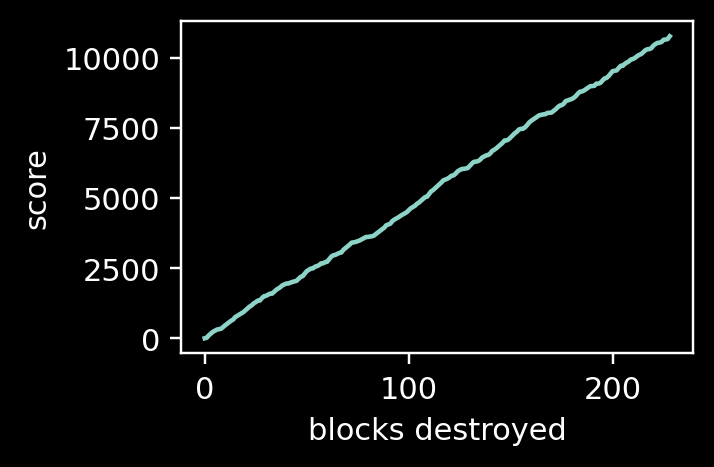

In [302]:
# I'm curious as to whether the scoring formula could be deduced
# ... but apparently not.

# (blocks destroyed, score)
c_cade.scores.append([0, 10776])
bs = np.array(c_cade.scores[1:])
destroyed = bs[0,0] - bs[:,0] # ;print(destroyed)
scores = bs[:,1] # ; print(scores)

plt.figure(dpi=220, figsize=(3, 2))
plt.xlabel('blocks destroyed')
plt.ylabel('score')
plt.style.use('dark_background')
plt.plot(destroyed, scores)
plt.show()

I may implement a python terminal curses version of this arcade game, just to see it in action. With or without user keyboard input.

---
## [Day 14](http://adventofcode.com/2019/day/14) : Space Stoichiometry